In [1]:
import torch

# get index of currently selected device
print(torch.cuda.current_device())

# get number of GPUs available
print(torch.cuda.device_count())

# get the name of the device
torch.cuda.get_device_name(0) 

0
1


'NVIDIA GeForce GTX 1050 Ti'

In [2]:
# Import required libraries
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from IPython.display import display, clear_output, Video, HTML
from base64 import b64encode
import ipywidgets as widgets

os.chdir('..\Videos')

In [3]:
def resize_frame(frame, scale_percent):
    """Resize frame based on percentage scale"""
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

def show_frame(video_path, frame_number):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise ValueError("Error opening the video file!")

    # Set the frame position
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = video.read()
    if not ret:
        raise ValueError(f"Could not read frame {frame_number}. Make sure it exists in the video.")

    # Convert frame from BGR to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title(f"Frame {frame_number}")
    plt.show()

    # Release the video object
    video.release()
    
def read_video(vid_path):
  video = cv2.VideoCapture(vid_path)
  ret, frame = video.read()
  # Original informations of video
  height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
  width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
  fps = video.get(cv2.CAP_PROP_FPS)
  total_f = video.get(cv2.CAP_PROP_FRAME_COUNT)

  print('Original Dim: ', (width, height))
  print('Total Frames: ', total_f)
  print('Original FPS: ', fps)
  print(f'Frame shape {frame.shape}\n')

  if ret:
    plt.imshow(frame[..., ::-1])
    plt.axis('off')
    plt.show()
  else:
      print("Failed to capture the first frame!")

  # Release the VideoCapture object
  video.release()
  return video

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [4]:
video_1 = "vid_1.mp4" 
video_1_output = "output_vid_1.mp4"

video_2 = "vid_2.mp4"
video_2_output = "output_vid_2.mp4"

Original Dim:  (3840, 2160)
Total Frames:  925.0
Original FPS:  30.0
Frame shape (2160, 3840, 3)



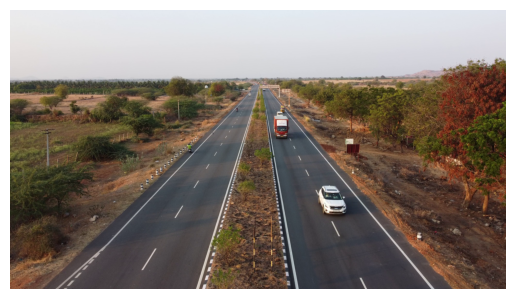

< cv2.VideoCapture 0000028A68B10630>

In [5]:
read_video(video_1)

Original Dim:  (3840, 2160)
Total Frames:  538.0
Original FPS:  25.0
Frame shape (2160, 3840, 3)



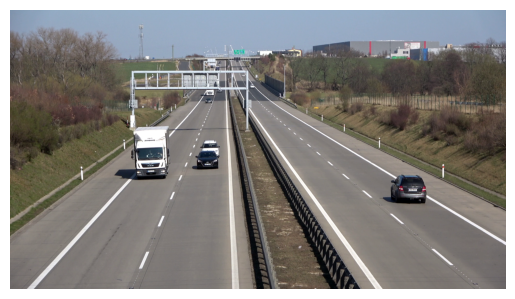

< cv2.VideoCapture 0000028A68B10970>

In [6]:
read_video(video_2)

## Detection

In [7]:
def prediction(source_path, output_path='output.mp4', conf_threshold=0.5, scale_percent=50, max_frame=2000, verbose=False, line_offset=5):

    class_IDS = [2, 3, 5, 7]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    model = YOLO("yolov8x.pt")
    
    # Define vehicle classes (COCO indices)
    vehicle_classes = {2: "car", 3: "motorbike", 5: "bus", 7: "truck"}
    

    # Open video capture
    cap = cv2.VideoCapture(source_path)
    if not cap.isOpened():
        raise Exception("Cannot open video file!")

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_f = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #Output
    frame_width = int(frame_width * scale_percent / 100)
    frame_height = int(frame_height * scale_percent / 100)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    print(f"Output dim: {frame_width}, {frame_height}")

    # Define the line in the middle of the frame
    line_y = frame_height // 3 * 2
    offset = line_offset  # Offset range for the line
    line_color = (255, 255, 255)
    line_thickness = 2

    # Vehicle counts for each class
    vehicle_count = {cls: 0 for cls in vehicle_classes.values()}

    progress = widgets.IntProgress(
        value=0,
        min=0,
        max=total_f,
        description='Processing:',
        bar_style='info',
        orientation='horizontal'
    )
    
    
    # Process video frame-by-frame
    print("[INFO] - Starting video processing...")
    for i in range(total_f):
        ret, frame = cap.read()
        if not ret or i >= max_frame:
            break

        progress.value = i

        frame = resize_frame(frame, scale_percent)

        # Run YOLOv8 inference on GPU
        results = model.predict(frame, conf = conf_threshold, classes = class_IDS, device = device, verbose = False)


         # Draw the line with offset ranges on the frame
        cv2.line(frame, (0, line_y), (frame_width, line_y), line_color, line_thickness)
        cv2.line(frame, (0, line_y - offset), (frame_width, line_y - offset), (255, 0, 0), 2)  # Upper offset
        cv2.line(frame, (0, line_y + offset), (frame_width, line_y + offset), (255, 0, 0), 2)  # Lower offset

        # Iterate through detections
        for result in results[0].boxes:
            cls_id = int(result.cls.cpu().numpy())  # Class ID
            conf = result.conf.cpu().numpy()  # Confidence score
            bbox = result.xyxy.cpu().numpy()[0]  # Bounding box [x1, y1, x2, y2]

            if cls_id in vehicle_classes:
                # Get the vehicle class
                vehicle_class = vehicle_classes[cls_id]

                # Get the bounding box center
                x1, y1, x2, y2 = map(int, bbox)
                cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

                # Check if the center of the bounding box is within the offset range
                if line_y - offset <= cy <= line_y + offset:
                    vehicle_count[vehicle_class] += 1

                # Draw bounding box and label
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"{vehicle_class} ({conf.item():.2f})"
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)  # Center point

        
        # Display vehicle count on frame
        y_offset = 30
        for cls, count in vehicle_count.items():
            cv2.putText(frame, f"{cls}: {count}", (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            y_offset += 30

        # Write the frame to the output video
        out.write(frame)
        
        # Process bar
        # if i % 30 == 0:  # Update display every 30 frames
        # #     clear_output(wait=True)
        #     display(progress)

        # Display the frame (optional)
        if verbose:
            cv2.imshow("YOLOv8 Vehicle Detection", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
    display(progress)            
    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return vehicle_count

Using device: cuda
Output dim: 1536, 864
[INFO] - Starting video processing...


C:\Users\nhatx\AppData\Local\Temp\ipykernel_10944\1589121167.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls_id = int(result.cls.cpu().numpy())  # Class ID


IntProgress(value=924, bar_style='info', description='Processing:', max=925)

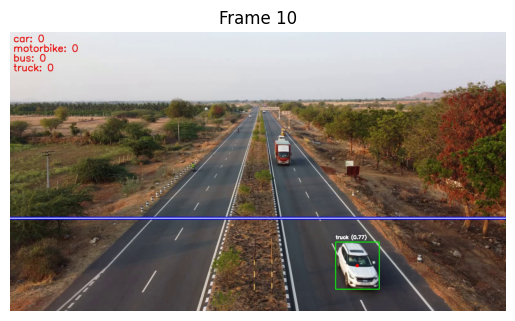

In [8]:
vid_1_result = prediction(video_1, video_1_output, scale_percent=40, verbose=False, line_offset=3)
show_frame(video_1_output, 10)

Using device: cuda
Output dim: 1536, 864
[INFO] - Starting video processing...


C:\Users\nhatx\AppData\Local\Temp\ipykernel_10944\1589121167.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls_id = int(result.cls.cpu().numpy())  # Class ID


IntProgress(value=537, bar_style='info', description='Processing:', max=538)

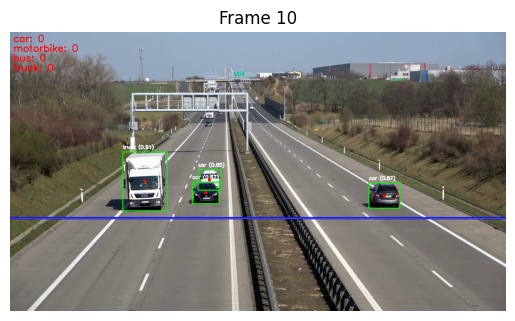

In [9]:
vid_2_result = prediction(video_2, video_2_output, scale_percent=40, verbose=False, line_offset=2)
show_frame(video_2_output, 10)

## Result

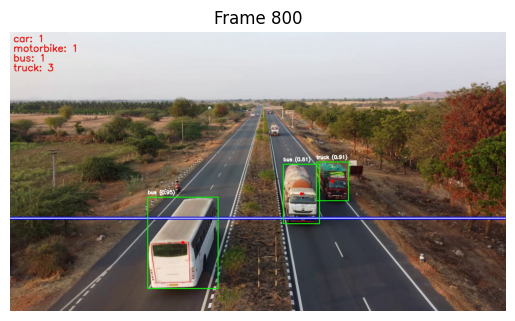

In [15]:
show_frame(video_1_output, 800)

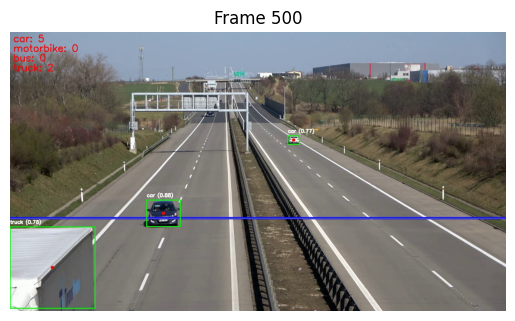

In [17]:
show_frame(video_2_output, 500)

In [12]:
vid_1_df = pd.DataFrame(list(vid_1_result.items()), columns=['Class', 'Count'])

# Display the DataFrame
vid_1_df

,Class,Count
0,car,1
1,motorbike,1
2,bus,2
3,truck,5


In [13]:
vid_2_df = pd.DataFrame(list(vid_2_result.items()), columns=['Class', 'Count'])

# Display the DataFrame
vid_2_df

,Class,Count
0,car,6
1,motorbike,0
2,bus,0
3,truck,2
